In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import Perceptron,PassiveAggressiveClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from scikitplot.metrics import plot_roc_curve

from sklearn.preprocessing import StandardScaler,MinMaxScaler

import os
from functools import reduce

import seaborn as sns
%matplotlib inline


# Lectura de datos

In [2]:
ruta='/home/oszwaldo/Documentos/Projects/Kaggle/titanic'

l_arch=[os.path.join(ruta,a) for a in os.listdir(ruta) if a.endswith('.csv') ]
l_arch

['/home/oszwaldo/Documentos/Projects/Kaggle/titanic/prueba.csv',
 '/home/oszwaldo/Documentos/Projects/Kaggle/titanic/gender_submission.csv',
 '/home/oszwaldo/Documentos/Projects/Kaggle/titanic/prueba1.csv',
 '/home/oszwaldo/Documentos/Projects/Kaggle/titanic/test.csv',
 '/home/oszwaldo/Documentos/Projects/Kaggle/titanic/train.csv']

In [3]:
df = pd.read_csv(l_arch[-1])
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
vard=['Pclass','Sex','Embarked'] # Cabin tal vez
varori=['Age','SibSp','Parch','Fare'] # variables continuas originales
um='PassengerId'
tgt='Survived'
#df[varc].head()

In [5]:
df.loc[:,[um]+vard].head(2)

,PassengerId,Pclass,Sex,Embarked
0,1,3,male,S
1,2,1,female,C


# Ingeniería de datos

In [6]:
def trans(df,v,varori):
    aux=df.pivot_table(index=um,columns=v,values=varori,aggfunc=['min','max','mean','std','sum']).fillna(0)
    aux.columns=["v_"+v+"_"+"".join(str(x[2]))+"_"+"".join(x[1])+"_"+"".join(x[0]) for x in aux.columns]
    return aux

In [7]:
# Parte necesaria para los nuevos datos
X=reduce(lambda x,y:pd.merge(x,y,on=um,how='outer'), map(lambda v:trans(df,v,varori),vard) )
# Se definen nuevas variables continuas
varc=[a for a in X.columns if a[:2]=='v_']

In [8]:
X.head(2)

,v_Pclass_1_Age_min,v_Pclass_2_Age_min,v_Pclass_3_Age_min,v_Pclass_1_Fare_min,v_Pclass_2_Fare_min,v_Pclass_3_Fare_min,v_Pclass_1_Parch_min,v_Pclass_2_Parch_min,v_Pclass_3_Parch_min,v_Pclass_1_SibSp_min,...,v_Embarked_S_Age_sum,v_Embarked_C_Fare_sum,v_Embarked_Q_Fare_sum,v_Embarked_S_Fare_sum,v_Embarked_C_Parch_sum,v_Embarked_Q_Parch_sum,v_Embarked_S_Parch_sum,v_Embarked_C_SibSp_sum,v_Embarked_Q_SibSp_sum,v_Embarked_S_SibSp_sum
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,22.0,0.0000,0.0,7.25,0.0,0.0,0.0,0.0,...,22.0,0.0000,0.0,7.25,0.0,0.0,0.0,0.0,0.0,1.0
2,38.0,0.0,0.0,71.2833,0.0,0.00,0.0,0.0,0.0,1.0,...,0.0,71.2833,0.0,0.00,0.0,0.0,0.0,1.0,0.0,0.0


In [9]:
tad=pd.merge(X,df[[um]+[tgt]],on=um,how="inner")
tad.shape

(891, 130)

# Análisis exploratorio

## Missings

In [10]:
miss=1-tad[varc].describe().T[['count']]/len(tad)
miss

,count
v_Pclass_1_Age_min,0.000000
v_Pclass_2_Age_min,0.000000
v_Pclass_3_Age_min,0.000000
v_Pclass_1_Fare_min,0.000000
v_Pclass_2_Fare_min,0.000000
...,...
v_Embarked_Q_Parch_sum,0.002245
v_Embarked_S_Parch_sum,0.002245
v_Embarked_C_SibSp_sum,0.002245
v_Embarked_Q_SibSp_sum,0.002245


In [11]:
tad.shape,tad.dropna().shape

((891, 130), (889, 130))

In [12]:
tad=tad.dropna().reset_index(drop=True)
tad.tail()

,PassengerId,v_Pclass_1_Age_min,v_Pclass_2_Age_min,v_Pclass_3_Age_min,v_Pclass_1_Fare_min,v_Pclass_2_Fare_min,v_Pclass_3_Fare_min,v_Pclass_1_Parch_min,v_Pclass_2_Parch_min,v_Pclass_3_Parch_min,...,v_Embarked_C_Fare_sum,v_Embarked_Q_Fare_sum,v_Embarked_S_Fare_sum,v_Embarked_C_Parch_sum,v_Embarked_Q_Parch_sum,v_Embarked_S_Parch_sum,v_Embarked_C_SibSp_sum,v_Embarked_Q_SibSp_sum,v_Embarked_S_SibSp_sum,Survived
884,887,0.0,27.0,0.0,0.0,13.0,0.00,0.0,0.0,0.0,...,0.0,0.00,13.00,0.0,0.0,0.0,0.0,0.0,0.0,0
885,888,19.0,0.0,0.0,30.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.00,30.00,0.0,0.0,0.0,0.0,0.0,0.0,1
886,889,0.0,0.0,0.0,0.0,0.0,23.45,0.0,0.0,2.0,...,0.0,0.00,23.45,0.0,0.0,2.0,0.0,0.0,1.0,0
887,890,26.0,0.0,0.0,30.0,0.0,0.00,0.0,0.0,0.0,...,30.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1
888,891,0.0,0.0,32.0,0.0,0.0,7.75,0.0,0.0,0.0,...,0.0,7.75,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0


## Extremos

In [13]:
ol = tad[varc].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values.tolist()
for v,li,ls in ol:
    tad['ol_%s'%v] = ((tad[v]<li)|(tad[v]>ls)).astype(int)

In [14]:
varo = [v for v in tad.columns if v[:2]=='ol']
tad['ext'] = tad[varo].max(axis=1)

In [15]:
tad.drop(varo,axis=1,inplace=True)

In [16]:
tad.head(2)

,PassengerId,v_Pclass_1_Age_min,v_Pclass_2_Age_min,v_Pclass_3_Age_min,v_Pclass_1_Fare_min,v_Pclass_2_Fare_min,v_Pclass_3_Fare_min,v_Pclass_1_Parch_min,v_Pclass_2_Parch_min,v_Pclass_3_Parch_min,...,v_Embarked_Q_Fare_sum,v_Embarked_S_Fare_sum,v_Embarked_C_Parch_sum,v_Embarked_Q_Parch_sum,v_Embarked_S_Parch_sum,v_Embarked_C_SibSp_sum,v_Embarked_Q_SibSp_sum,v_Embarked_S_SibSp_sum,Survived,ext
0,1,0.0,0.0,22.0,0.0000,0.0,7.25,0.0,0.0,0.0,...,0.0,7.25,0.0,0.0,0.0,0.0,0.0,1.0,0,0
1,2,38.0,0.0,0.0,71.2833,0.0,0.00,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,1.0,0.0,0.0,1,0


In [17]:
# Nos quedamos solo con las filas que no son extremas
tad=tad.loc[tad.ext==0].reset_index(drop=True).drop('ext',axis=1)

In [18]:
# Eliminación de columnas innecesarias o unarias
mat=tad[varc].describe().T[['max']]
columnas=mat.loc[mat['max']<=1].T.columns.to_list()
tad=tad.drop(columnas,axis=1)
varc=[a for a in tad.columns if a[:2]=='v_']

## Correlación

In [19]:
mat=tad[varc].corr()
n=len(mat)
li=0.90
nom=[]
for i in range(1,n):
    if(mat.iloc[i].name in nom):
        continue
    for j in range(i+1,n):
        if(mat.iloc[i,j]>li or mat.iloc[i,j]<(-li)):
            nom.append(mat.iloc[:,j].name)
tad=tad.drop(nom,axis=1)
varc=[a for a in tad.columns if a[:2]=='v_']

In [20]:
tad.head()

,PassengerId,v_Pclass_1_Age_min,v_Pclass_2_Age_min,v_Pclass_3_Age_min,v_Pclass_1_Fare_min,v_Pclass_2_Fare_min,v_Pclass_3_Fare_min,v_Pclass_1_Parch_min,v_Pclass_2_Parch_min,v_Pclass_3_Parch_min,...,v_Embarked_C_Age_min,v_Embarked_Q_Age_min,v_Embarked_S_Age_min,v_Embarked_C_Fare_min,v_Embarked_Q_Fare_min,v_Embarked_S_Fare_min,v_Embarked_C_Parch_min,v_Embarked_S_Parch_min,v_Embarked_S_SibSp_min,Survived
0,1,0.0,0.0,22.0,0.0000,0.0,7.250,0.0,0.0,0.0,...,0.0,0.0,22.0,0.0000,0.0,7.250,0.0,0.0,1.0,0
1,2,38.0,0.0,0.0,71.2833,0.0,0.000,0.0,0.0,0.0,...,38.0,0.0,0.0,71.2833,0.0,0.000,0.0,0.0,0.0,1
2,3,0.0,0.0,26.0,0.0000,0.0,7.925,0.0,0.0,0.0,...,0.0,0.0,26.0,0.0000,0.0,7.925,0.0,0.0,0.0,1
3,4,35.0,0.0,0.0,53.1000,0.0,0.000,0.0,0.0,0.0,...,0.0,0.0,35.0,0.0000,0.0,53.100,0.0,0.0,1.0,1
4,5,0.0,0.0,35.0,0.0000,0.0,8.050,0.0,0.0,0.0,...,0.0,0.0,35.0,0.0000,0.0,8.050,0.0,0.0,0.0,0


array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'v_Pclass_1_Age_min'}>,
        <AxesSubplot:title={'center':'v_Pclass_2_Age_min'}>,
        <AxesSubplot:title={'center':'v_Pclass_3_Age_min'}>,
        <AxesSubplot:title={'center':'v_Pclass_1_Fare_min'}>],
       [<AxesSubplot:title={'center':'v_Pclass_2_Fare_min'}>,
        <AxesSubplot:title={'center':'v_Pclass_3_Fare_min'}>,
        <AxesSubplot:title={'center':'v_Pclass_1_Parch_min'}>,
        <AxesSubplot:title={'center':'v_Pclass_2_Parch_min'}>,
        <AxesSubplot:title={'center':'v_Pclass_3_Parch_min'}>],
       [<AxesSubplot:title={'center':'v_Pclass_3_SibSp_min'}>,
        <AxesSubplot:title={'center':'v_Pclass_1_Age_max'}>,
        <AxesSubplot:title={'center':'v_Sex_female_Age_min'}>,
        <AxesSubplot:title={'center':'v_Sex_male_Age_min'}>,
        <AxesSubplot:title={'center':'v_Sex_female_Fare_min'}>],
       [<AxesSubplot:title={'center':'v_Sex_male_Fare_min'}>,
        <Ax

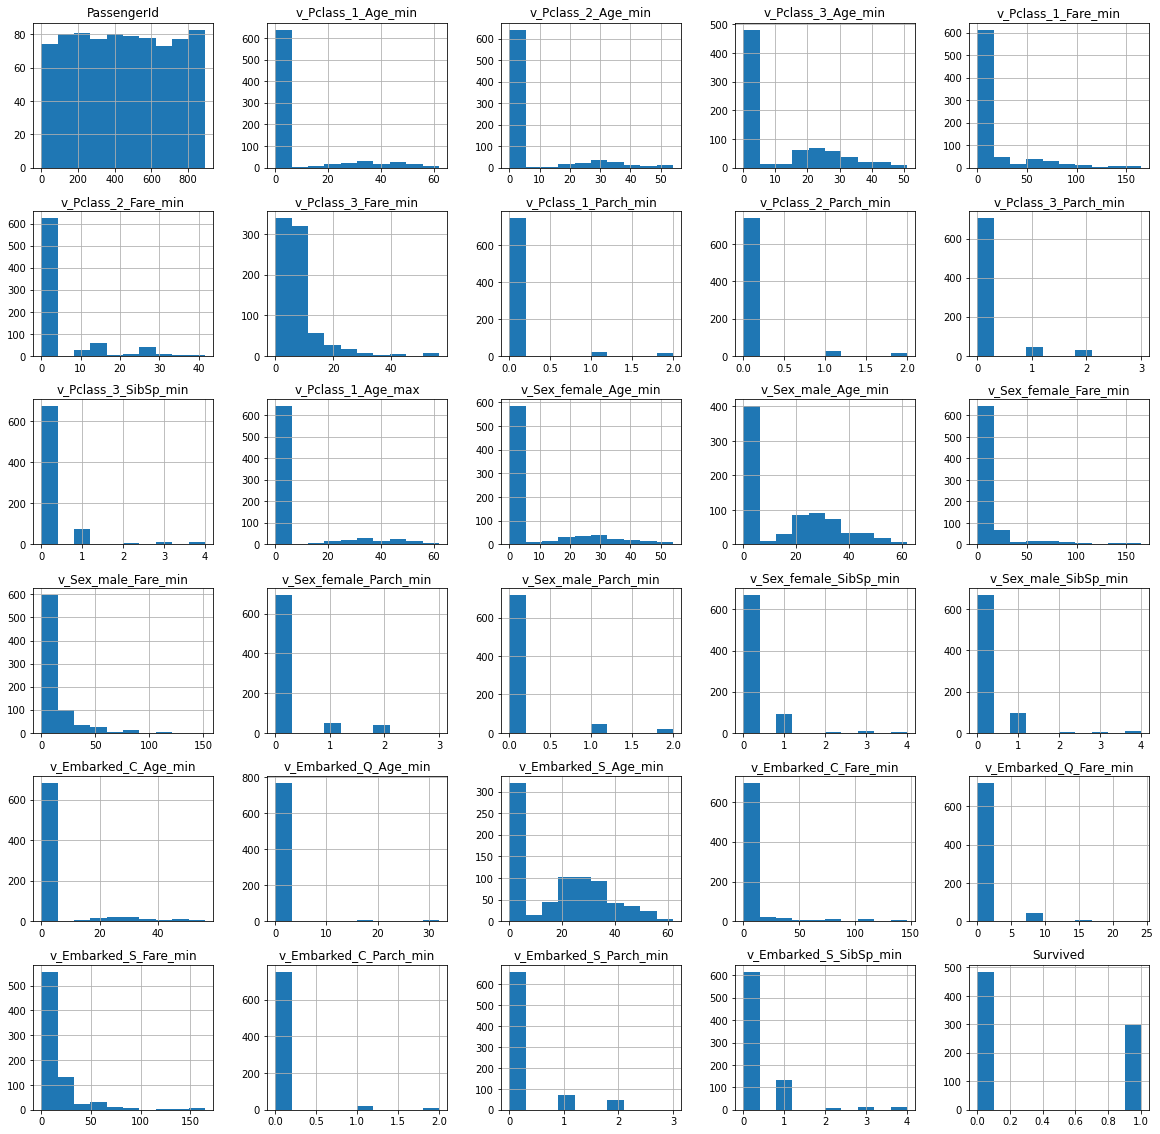

In [21]:
tad.hist(figsize=(20,20))

# Modelos

## Perceptron

In [22]:
X=tad[varc].copy()
y=tad[tgt]
Xt,Xv,yt,yv = train_test_split(X,y,train_size=0.7)

In [23]:
modelo = Perceptron()

In [131]:
#l2 es la norma cuadrada euclidiana y l1 es la norma absoluta, elasticnet es una combinación
#Se aplica el penalty a la función de perdida 0-1 del perceptron
hyper = dict(penalty = ['l2','l1','elasticnet'],
             fit_intercept=[True,False],
             max_iter=range(1000,21000,1000),
             eta0 = np.arange(0.1,1,0.1))

In [132]:
grid = GridSearchCV(estimator=modelo,
                    error_score='roc_auc',
                    param_grid=hyper,
                    cv=3,
                    n_jobs=-1,
                    verbose=True)

grid.fit(Xt,yt)

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 1346 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:   51.8s finished


GridSearchCV(cv=3, error_score='roc_auc', estimator=Perceptron(), n_jobs=-1,
             param_grid={'eta0': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'fit_intercept': [True, False],
                         'max_iter': range(1000, 21000, 1000),
                         'penalty': ['l2', 'l1', 'elasticnet']},
             verbose=True)

In [133]:
print(grid.best_score_)

print(grid.best_params_)

0.7714826157449108
{'eta0': 0.6, 'fit_intercept': False, 'max_iter': 1000, 'penalty': 'l2'}


In [134]:
modelo = grid.best_estimator_
modelo.fit(Xt,yt)

Perceptron(eta0=0.6, fit_intercept=False, penalty='l2')

In [135]:
print(accuracy_score(y_true=yt,y_pred=modelo.predict(Xt)))
print(accuracy_score(y_true=yv,y_pred=modelo.predict(Xv)))

print(confusion_matrix(y_true=yt,y_pred=modelo.predict(Xt)))
print(confusion_matrix(y_true=yv,y_pred=modelo.predict(Xv)))

0.7239488117001828
0.7191489361702128
[[272  63]
 [ 88 124]]
[[113  37]
 [ 29  56]]


## Pasivo-agresivo

In [234]:
modelo = PassiveAggressiveClassifier()

In [235]:
hyper = dict(C = np.arange(0.1,2,0.1),
             fit_intercept=[True,False],
             max_iter=range(1000,21000,1000))

In [236]:
grid = GridSearchCV(estimator=modelo,
                    error_score='roc_auc',
                    param_grid=hyper,
                    cv=3,
                    n_jobs=-1,
                    verbose=True)

grid.fit(Xt,yt)

Fitting 3 folds for each of 760 candidates, totalling 2280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1332 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 2280 out of 2280 | elapsed:   35.0s finished


GridSearchCV(cv=3, error_score='roc_auc',
             estimator=PassiveAggressiveClassifier(), n_jobs=-1,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
                         'fit_intercept': [True, False],
                         'max_iter': range(1000, 21000, 1000)},
             verbose=True)

In [237]:
print(grid.best_score_)

print(grid.best_params_)

0.8080726195480294
{'C': 0.4, 'fit_intercept': False, 'max_iter': 10000}


In [253]:
modelo = grid.best_estimator_
modelo.fit(Xt,yt)

PassiveAggressiveClassifier(C=0.4, fit_intercept=False, max_iter=10000)

In [254]:
print(accuracy_score(y_true=yt,y_pred=modelo.predict(Xt)))
print(accuracy_score(y_true=yv,y_pred=modelo.predict(Xv)))

print(confusion_matrix(y_true=yt,y_pred=modelo.predict(Xt)))
print(confusion_matrix(y_true=yv,y_pred=modelo.predict(Xv)))

0.7879341864716636
0.7787234042553192
[[319  24]
 [ 92 112]]
[[135   7]
 [ 45  48]]


## Maquina vector-soporte

In [183]:
y = tad[tgt]
X = tad[varc].copy()
Xt,Xv,yt,yv = train_test_split(X,y,train_size=0.7)

In [184]:
modelo = SVC()

In [185]:
hyper = dict(C = np.arange(0.1,2,0.1),
             kernel=['linear', 'poly', 'rbf', 'sigmoid'],
             degree=range(2,6),
             gamma = ['scale', 'auto'],
             probability = [True]
            )

In [186]:
sc = MinMaxScaler()
sc.fit(X)

MinMaxScaler()

In [187]:
Xt = pd.DataFrame(sc.transform(Xt),columns=varc)
Xv = pd.DataFrame(sc.transform(Xv),columns=varc)

In [188]:
grid = RandomizedSearchCV(estimator=modelo,
                    error_score='roc_auc',
                    param_distributions=hyper,
                    n_iter=200,
                    cv=3,
                    n_jobs=-1,
                    verbose=True)

grid.fit(Xt,yt)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   45.0s finished


RandomizedSearchCV(cv=3, error_score='roc_auc', estimator=SVC(), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
                                        'degree': range(2, 6),
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid'],
                                        'probability': [True]},
                   verbose=True)

In [189]:
print(grid.best_score_)
print(grid.best_params_)

0.7934206048960147
{'probability': True, 'kernel': 'rbf', 'gamma': 'scale', 'degree': 4, 'C': 1.6}


In [202]:
modelo = grid.best_estimator_

modelo.fit(Xt,yt)

SVC(C=1.6, degree=4, probability=True)

In [203]:
print(accuracy_score(y_true=yt,y_pred=modelo.predict(Xt)))
print(accuracy_score(y_true=yv,y_pred=modelo.predict(Xv)))

print(confusion_matrix(y_true=yt,y_pred=modelo.predict(Xt)))
print(confusion_matrix(y_true=yv,y_pred=modelo.predict(Xv)))

print(roc_auc_score(y_true=yt,y_score=modelo.predict_proba(Xt)[:,1]))
print(roc_auc_score(y_true=yv,y_score=modelo.predict_proba(Xv)[:,1]))

0.8336380255941499
0.7574468085106383
[[335  12]
 [ 79 121]]
[[127  11]
 [ 46  51]]
0.8765706051873199
0.8436799641416405


In [ ]:
plot_roc_curve(y_true=yt,y_probas=modelo.predict_proba(Xt),curves='macro')
plot_roc_curve(y_true=yv,y_probas=modelo.predict_proba(Xv),curves='macro')

# Prueba con datos desconocidos

In [256]:
l_arch

['/home/oszwaldo/Documentos/Projects/Kaggle/titanic/prueba.csv',
 '/home/oszwaldo/Documentos/Projects/Kaggle/titanic/gender_submission.csv',
 '/home/oszwaldo/Documentos/Projects/Kaggle/titanic/test.csv',
 '/home/oszwaldo/Documentos/Projects/Kaggle/titanic/train.csv']

In [258]:
test=pd.read_csv(l_arch[2])
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [260]:
Xtest=reduce(lambda x,y:pd.merge(x,y,on=um,how='outer'), map(lambda v:trans(test,v,varori),vard) )

In [273]:
pre=modelo.predict(Xtest[varc])
pre=pd.DataFrame(pre)
pre.columns=[um+tgt]

In [ ]:
# Formato
lista=test.loc[:,'PassengerId'].to_list()
lista=pd.DataFrame(lista)
pre=pd.merge(pre,lista,on=pre.index)
pre=pre.drop("key_0",axis=1)
pre.columns=[tgt,um]

In [283]:
pre.head(1)

,Survived,PassengerId
0,0,892


In [284]:
pre.to_csv("prueba1.csv",index=False)